# Minerva: AI Guardian for Scam Protection

This notebook implements a multi-agent system for analyzing images (screenshots) to identify scam attempts, and provide personalized scam prevention. It uses [AutoGen](https://github.com/microsoft/autogen/) to orchestrate various specialized agents that work together.

Benefits:
- Automates the process of identifying suspicious scam patterns.
- Prevent Financial Loss
- Save Time: Early scam detection reduces the number of claims filed by end-users.

## Install Dependencies

In [1]:
%pip install -q autogen-agentchat~=0.2 pillow pytesseract pyyaml

Note: you may need to restart the kernel to use updated packages.


In [2]:
import autogen

from IPython.display import Image as IPImage
from IPython.display import display

flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.


In [27]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

config_list = [
    {
        "model": "gpt-4o-mini",
        "api_key": os.getenv("OPENAI_API_KEY")
    }
]

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}

In [28]:
import yaml

with open('config/agents.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Agents Creation

In [29]:
def create_agents():

    ocr_agent = autogen.AssistantAgent(
        name="OCR_Specialist",
        system_message=config['ocr_agent']['assignment'],
        llm_config=llm_config
    )
   
    content_agent = autogen.AssistantAgent(
        name="Content_Analyst",
        system_message=config['content_agent']['assignment'],
        llm_config=llm_config
    )

    decision_agent = autogen.AssistantAgent(
        name="Decision_Maker",
        system_message=config['decision_agent']['assignment'],
        llm_config=llm_config
    )

    summary_agent = autogen.AssistantAgent(
        name="Summary_Agent",
        description="Generates a summary of the findings",
        system_message=config['summary_agent']['assignment'],
        llm_config=llm_config
    )

    user_proxy = autogen.UserProxyAgent(
        name="user_proxy",
        is_termination_msg=lambda msg: "ANALYSIS_COMPLETE" in msg.get("content", ""),
        human_input_mode="NEVER",
        max_consecutive_auto_reply=10,
    )

    @user_proxy.register_for_execution()
    @ocr_agent.register_for_llm(description="Extracts text from an image path")
    def ocr(image_path: str) -> str:
        from PIL import Image
        import pytesseract

        try:
            image = Image.open(image_path)
            text = pytesseract.image_to_string(image)
            return text
        except Exception as e:
            return f"Error in text extraction: {str(e)}"
    
    return ocr_agent, content_agent, decision_agent, summary_agent, user_proxy

## Workflow

In [30]:
class ScamDetectionWorkflow:
    def __init__(self):
        self.ocr_agent, self.content_agent, self.decision_agent, self.summary_agent, self.user_proxy = create_agents()
        
    def analyze(self, image_path):
        """Coordinate the multi-agent analysis.
        """
        
        groupchat = autogen.GroupChat(
            agents=[self.ocr_agent, self.content_agent, self.decision_agent, self.summary_agent, self.user_proxy],
            messages=[],
            max_round=15,
        )
        manager = autogen.GroupChatManager(groupchat=groupchat)

        messages = self.user_proxy.initiate_chat(
            manager,
            message=f"""
            1. OCR Agent: Extract text from this image: {image_path}
            2. Content Agent: Evaluate the messaging and claims
            3. Decision Maker: Synthesize all analyses and make final determination
            4. Summarize the findings""",
        )

        return messages

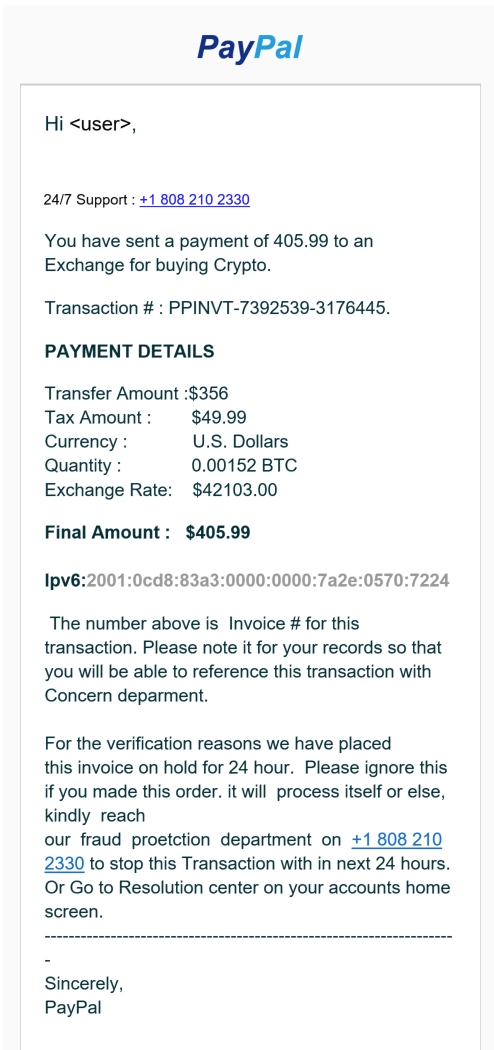

In [47]:
#image_path = "./samples/02.giftcard.message.scam.png"
#image_path = "./samples/74.customer.service.twitter.scam.png"
#image_path = "./samples/42.amazon.email.scam.png"
#image_path = "./samples/22.giveaway.email.scam.png"
#image_path = "./samples/32.multifactor.email.scam.png"
image_path = "./samples/39.paypal.email.scam.png"
display(IPImage(filename=image_path))

In [48]:
workflow = ScamDetectionWorkflow()
results = workflow.analyze(image_path)

user_proxy (to chat_manager):


            1. OCR Agent: Extract text from this image: ./samples/39.paypal.email.scam.png
            2. Content Agent: Evaluate the messaging and claims
            3. Decision Maker: Synthesize all analyses and make final determination
            4. Summarize the findings

--------------------------------------------------------------------------------

Next speaker: OCR_Specialist



OCR_Specialist (to chat_manager):

***** Suggested tool call (call_M3OAdzHAg854j7eDIq59bUik): ocr *****
Arguments: 
{"image_path":"./samples/39.paypal.email.scam.png"}
********************************************************************

--------------------------------------------------------------------------------

Next speaker: user_proxy


>>>>>>>> EXECUTING FUNCTION ocr...
user_proxy (to chat_manager):

user_proxy (to chat_manager):

***** Response from calling tool (call_M3OAdzHAg854j7eDIq59bUik) *****
PayPal
Hi <user>,

24/7 Support : +1 808 210 2330

You have sent a payment of 405.99 to an
Exchange for buying Crypto.

Transaction # : PPINVT-7392539-3176445.
PAYMENT DETAILS

Transfer Amount :$356

Tax Amount : $49.99
Currency : U.S. Dollars
Quantity : 0.00152 BTC
Exchange Rate: $42103.00

Final Amount: $405.99

Ipv6:2001:0cd8:83a3:0000:0000:7a2e:0570:7224

The number above is Invoice # for this
transaction. Please note it for your records so that
you will be able to reference t

In [49]:
import pprint

pprint.pprint(results.chat_history[-1])

{'content': 'This email is highly likely to be a phishing scam pretending to '
            'be from PayPal. It uses common scam tactics such as a generic '
            'greeting, an unsolicited transaction notification, and a sense of '
            'urgency by saying the invoice will be processed unless action is '
            'taken within 24 hours. The grammar errors and unusual phrasing '
            'further reduce its authenticity. The provided contact number is '
            'likely designed to extract personal information. As a safe '
            'measure, do not interact with this message, report it as '
            'phishing, and avoid clicking any links or calling any listed '
            'numbers. TASK_COMPLETE',
 'name': 'Summary_Agent',
 'role': 'user'}


In [46]:
import json


with open('results.json', 'w') as json_file:
    json.dump(results.__dict__, json_file, indent=4)

In [151]:
results.summary

"This message claims that you've won a $1,000 Walmart gift card, a common tactic used in scams to lure individuals. It uses urgent language encouraging immediate action, which typically puts pressure on recipients to act without thinking. Additionally, a suspicious shortened URL is included, often leading to phishing sites or harmful content. Given these factors, this message is highly likely a scam. **Recommendation**: Do not click on any links or provide any personal information; delete the message and report it. \n\nTASK_COMPLETE"